<a href="https://colab.research.google.com/github/AlexMatheusAlves/modelos_churn/blob/main/Modelo_preditivos_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importando bibliotecas necessárias

import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
# Carregando o dataset
df = pd.read_csv('/content/Churn_Modelling.csv')

# Criar nova coluna StatusCliente com base em Exited
df['StatusCliente'] = df['Exited'].map({0: 'Ativo', 1: 'Inativo'})

# Criar cópia para modelagem, mantendo todas colunas originais
df_model = df.copy()

# Label Encoding para 'Gender'
df_model['Gender_Encoded'] = LabelEncoder().fit_transform(df_model['Gender'])

# One Hot Encoding para 'Geography' (mantendo coluna original)
df_dummies = pd.get_dummies(df_model['Geography'], prefix='Geo', drop_first=False)
df_model = pd.concat([df_model, df_dummies], axis=1)

# Normalização de colunas numéricas (mantendo originais)
scaler = MinMaxScaler()
df_model[['Age_norm', 'Balance_norm', 'EstimatedSalary_norm']] = scaler.fit_transform(
    df_model[['Age', 'Balance', 'EstimatedSalary']]
)

# Features para os modelos (não remove colunas originais)
features = [
    'CreditScore', 'Gender_Encoded', 'Age_norm', 'Tenure', 'Balance_norm',
    'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary_norm',
    'Geo_France', 'Geo_Germany', 'Geo_Spain'
]
X = df_model[features]
y = df_model['Exited']

# Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Modelo 1: Regressão Logística**

In [4]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

**Modelo 2: Random Forest**

In [5]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**Modelo 3: XGBoost**

In [6]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

**Previsões e probabilidades**



In [7]:
y_pred_lr = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

y_pred_xgb = model_xgb.predict(X_test)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

**Função de avaliação**

In [8]:
def avaliar_modelo(nome, y_true, y_pred, y_proba):
    print(f"\n=== {nome} ===")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_proba):.4f}")

**Avaliação**

In [9]:
avaliar_modelo("Regressão Logística", y_test, y_pred_lr, y_proba_lr)
avaliar_modelo("Random Forest", y_test, y_pred_rf, y_proba_rf)
avaliar_modelo("XGBoost", y_test, y_pred_xgb, y_proba_xgb)


=== Regressão Logística ===
Acurácia: 0.8120
Precisão: 0.5639
Recall: 0.1908
F1-Score: 0.2852
AUC-ROC: 0.7782

=== Random Forest ===
Acurácia: 0.8660
Precisão: 0.7572
Recall: 0.4682
F1-Score: 0.5786
AUC-ROC: 0.8574

=== XGBoost ===
Acurácia: 0.8625
Precisão: 0.7063
Recall: 0.5140
F1-Score: 0.5950
AUC-ROC: 0.8531


**Classifica risco**

0.00 a 0.33	Baixo Risco
0.34 a 0.66	Médio Risco
0.67 a 1.00	Alto Risco




In [10]:
# Criar colunas de risco com valor padrão
df['Risco_LR'] = 'Não Avaliado'
df['Risco_RF'] = 'Não Avaliado'
df['Risco_XGB'] = 'Não Avaliado'

# Função para classificar risco baseado na probabilidade
def classificar_risco(prob):
    if prob >= 0.7:
        return 'Alto Risco'
    elif prob >= 0.4:
        return 'Médio Risco'
    else:
        return 'Baixo Risco'

#
test_indices = X_test.index

df.loc[test_indices, 'Risco_LR'] = [classificar_risco(p) for p in y_proba_lr]
df.loc[test_indices, 'Risco_RF'] = [classificar_risco(p) for p in y_proba_rf]
df.loc[test_indices, 'Risco_XGB'] = [classificar_risco(p) for p in y_proba_xgb]

**coluna nova sobre status descrito**

In [11]:
df['ChurnStatus'] = df['Exited'].map({0: 'Ativo', 1: 'Inativo'})

In [12]:
df.to_excel('Churn_Modelling_tratado_v2.xlsx', index=False)

# **Analises**

In [14]:
# Contagem de churn vs não churn
print(df['StatusCliente'].value_counts())

StatusCliente
Ativo      7963
Inativo    2037
Name: count, dtype: int64


**Histogramas por status do cliente**

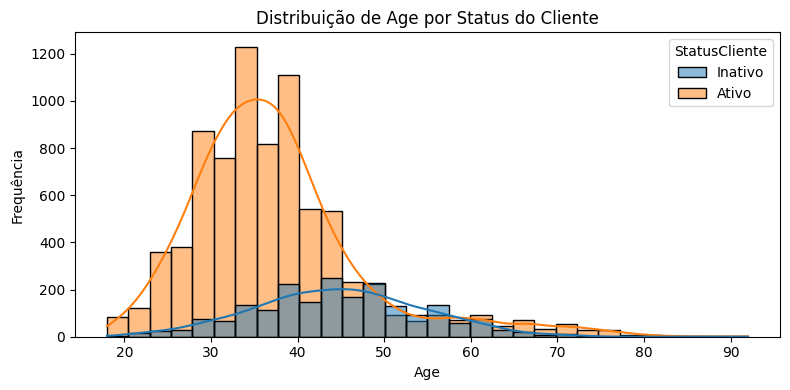

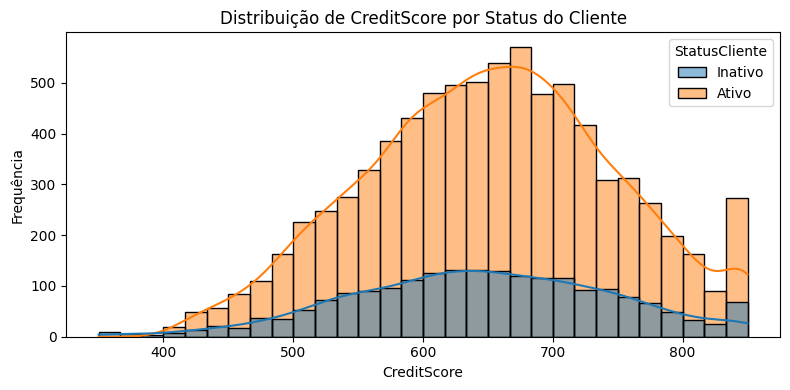

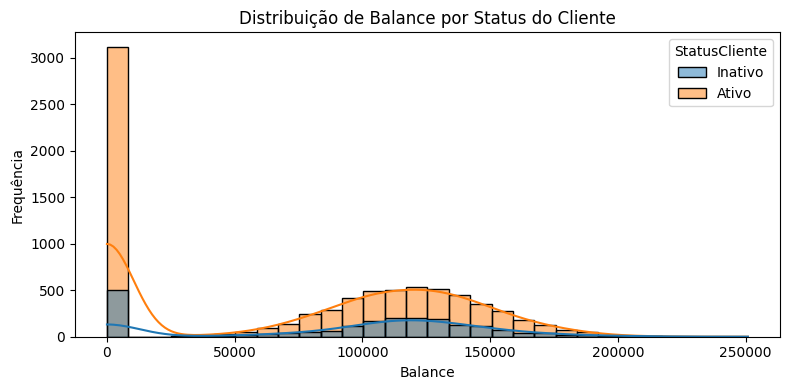

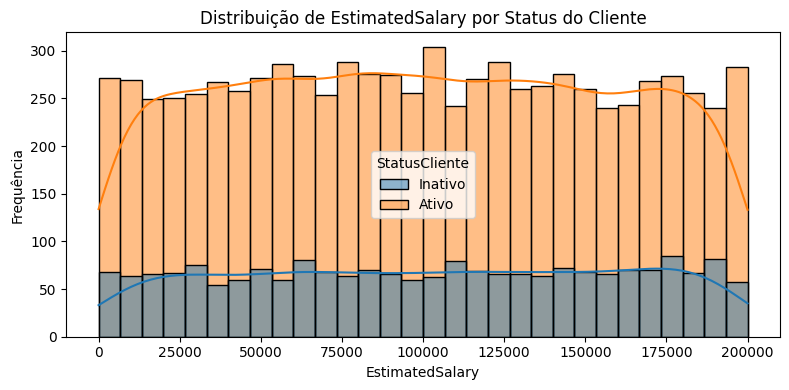

In [15]:
# Comparando distribuições por churn
for coluna in ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=coluna, hue='StatusCliente', kde=True, bins=30)
    plt.title(f'Distribuição de {coluna} por Status do Cliente')
    plt.xlabel(coluna)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()